In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

import pickle

In [2]:
!pip install pyarrow

In [3]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.head()
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.apply(lambda td: td.total_seconds()/60)
    df = df[((df.duration >=1) & (df.duration <=60))]

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    df[categorical] = df[categorical].astype(str)
    
    df.info()    
    return df

In [4]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898906 entries, 0 to 2964623
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

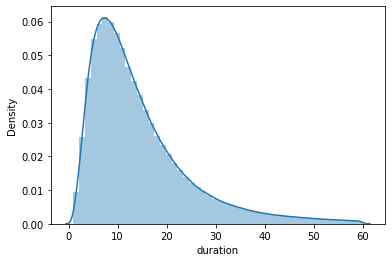

In [5]:
sns.distplot(df_train.duration)

In [6]:
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2938060 entries, 0 to 3007525
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [7]:
len(df_train), len(df_val)

(2898906, 2938060)

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [9]:
dv = DictVectorizer()

categorical = ['PU_DO']#'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [10]:
X_train
X_val

<2938060x24016 sparse matrix of type '<class 'numpy.float64'>'
	with 5867904 stored elements in Compressed Sparse Row format>

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared = False)

5.467172695979387

In [13]:
with open('models/lin_reg_bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out)

In [13]:
lr = Lasso()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared = False)

10.252110623751554

In [14]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared = False)

6.0583014573432905